# Fake News Prediction: Deep Learning BERT Model using TensorFlow-hub and Keras Tuner

#### Import Dependencies

In [1]:
import pandas as pd
from io import StringIO
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
string.punctuation
from google.colab import drive
drive.mount('drive')

Mounted at drive


#### Load Data into DataFrames

In [2]:
fake_url="https://raw.githubusercontent.com/Shannon-Watts/fake_news_ML/main/data/kaggle/Fake.csv"
fake_request = requests.get(fake_url).text
fake_df = pd.read_csv(StringIO(fake_request))
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
true_url= "https://raw.githubusercontent.com/Shannon-Watts/fake_news_ML/main/data/kaggle/True.csv"
true_request = requests.get(true_url).text
true_df = pd.read_csv(StringIO(true_request))
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Data Exploration

In [4]:
fake_df.nunique()

title      17903
text       17455
subject        6
date        1681
dtype: int64

In [5]:

true_df.nunique()

title      20826
text       21192
subject        2
date         716
dtype: int64

In [6]:
fake_df['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [7]:
true_df['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [8]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [9]:
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [10]:
fake_df.duplicated().sum()

3

In [11]:
true_df.duplicated().sum()

206

In [12]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [13]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [14]:
fake_df.shape

(23481, 4)

In [15]:
true_df.shape

(21417, 4)

#### Add `class` column, merge Dataframes, Clean Data

In [16]:
true_df['class'], fake_df['class'] = 1, 0

merged_df = pd.concat([true_df, fake_df], ignore_index = True, sort = False)

In [17]:
import copy
news_df = copy.deepcopy(merged_df)

In [18]:
import re
URLS = r'(https?://\S+)'
news_df['urlcount'] = news_df['date'].apply(lambda x: re.findall(URLS, x)).str.len()

news_df.loc[news_df['urlcount'] > 0]

,title,text,subject,date,class,urlcount
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0,1
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,0,1
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0,1
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0,1
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0,1
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0,1
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0,1
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0,1
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0,1


In [19]:
news_df['urlcount'].sum()

9

In [20]:
news_df.drop(news_df.loc[news_df['urlcount'] > 0].index, inplace=True)

In [21]:
news_df['urlcount'].sum()

0

In [22]:
news_df.duplicated().sum()

209

In [23]:
news_df.drop_duplicates(inplace=True)

In [24]:
news_df.duplicated().sum()

0

In [25]:
news_df.columns

Index(['title', 'text', 'subject', 'date', 'class', 'urlcount'], dtype='object')

In [26]:
news_df.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44680 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44680 non-null  object
 1   text      44680 non-null  object
 2   subject   44680 non-null  object
 3   date      44680 non-null  object
 4   class     44680 non-null  int64 
 5   urlcount  44680 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [27]:
news_df.shape

(44680, 6)

In [28]:
news_df['class'].value_counts()

0    23469
1    21211
Name: class, dtype: int64

In [29]:
news_df['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6833
left-news           4457
Government News     1568
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [30]:
news_df.drop(['text', 'date', 'subject', 'urlcount'], axis = 1, inplace = True)
news_df

,title,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44896,How to Blow $700 Million: Al Jazeera America F...,0


In [31]:
news_df.shape

(44680, 2)

In [32]:
news_df

,title,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44896,How to Blow $700 Million: Al Jazeera America F...,0


In [33]:
news_df.columns

Index(['title', 'class'], dtype='object')

In [34]:
# Shuffle the columns randomly
news_df = news_df.sample(frac = 1)

# Data Processing

In [35]:
news_df


,title,class
32567,"LIBERAL Lansing, MI Mayor Forced To REMOVE “Sa...",0
12131,U.S. says did everything possible to help Ital...,1
381,Factbox: Key Republicans in U.S. Senate tax bi...,1
36197,FOX NEWS REPORTER ASKS MAYOR Why She’s Using T...,0
40443,MIKE HUCKABEE: “Somebody Needs To Go To Prison...,0
...,...,...
24414,Trump Demands Apology From The Media And Gets...,0
28452,President Obama: Hillary Clinton Is Undoubted...,0
18581,Anti-government chants ring out on anniversary...,1
15736,Venezuela opposition coalition split ahead of ...,1


### Compile, Train and Evaluate the BERT Model

In [36]:
# Import evaluation dependcies
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")


In [37]:
# Split our data into our features and target arrays
from sklearn.model_selection import train_test_split
X = news_df['title'].values
y = news_df['class'].values
# Split the data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)

In [38]:
# Import Dependencies for Tensorflow-hub
!pip install tensorflow-text
import tensorflow_hub as hub
import tensorflow_text as text

# Use the Bert preprocesser and bert encoder from tensorflow_hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 15.2 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 1.6 MB 61.5 MB/s 
     |████████████████████████████████| 5.8 MB 52.7 MB/s 
     |████████████████████████████████| 438 kB 88.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [39]:
X_train.shape

(33510,)

In [40]:
def embed(headlines):
  processed = bert_preprocess(headlines)
  return bert_encoder(processed)['pooled_output']

In [41]:
import tensorflow as tf

# Input Layers
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='title')

# BERT layers
processed = bert_preprocess(input_layer)
output = bert_encoder(processed)

# Fully Connected Layers
layer = tf.keras.layers.Dropout(0.2, name='dropout')(output['pooled_output'])
layer = tf.keras.layers.Dense(10,activation='relu', name='hidden')(layer)
layer = tf.keras.layers.Dense(1,activation='sigmoid', name='output')(layer)



model = tf.keras.Model(inputs=[input_layer],outputs=[layer])

In [42]:
# Check the structure of the Bert model
summary = model.summary()
summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 news_title (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['news_title[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [46]:
#Compile model on adam optimizer, binary_crossentropy loss, and accuracy metrics
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Train model on 5 epochs
BERT = model.fit(X_train,y_train,epochs=5, validation_data=(X_test, y_test), validation_split=0.3, batch_size=32)
#Evaluate model on test data
model_loss, model_accuracy = model.evaluate(X_test,y_test)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/5
1048/1048 [==============================] - 8116s 8s/step - loss: 0.3379 - accuracy: 0.8547 - val_loss: 0.2567 - val_accuracy: 0.8960
Epoch 2/5
1048/1048 [==============================] - 8146s 8s/step - loss: 0.2929 - accuracy: 0.8762 - val_loss: 0.2566 - val_accuracy: 0.8933
Epoch 3/5
1048/1048 [==============================] - 8184s 8s/step - loss: 0.2798 - accuracy: 0.8852 - val_loss: 0.2270 - val_accuracy: 0.9092
Epoch 4/5
1048/1048 [==============================] - 8166s 8s/step - loss: 0.2742 - accuracy: 0.8875 - val_loss: 0.2259 - val_accuracy: 0.9055
Epoch 5/5
350/350 [==============================] - 2042s 6s/step - loss: 0.2381 - accuracy: 0.8968
Loss: 0.23810851573944092, Accuracy: 0.8967770934104919


In [ ]:
y_pred = model.predict(X_test)

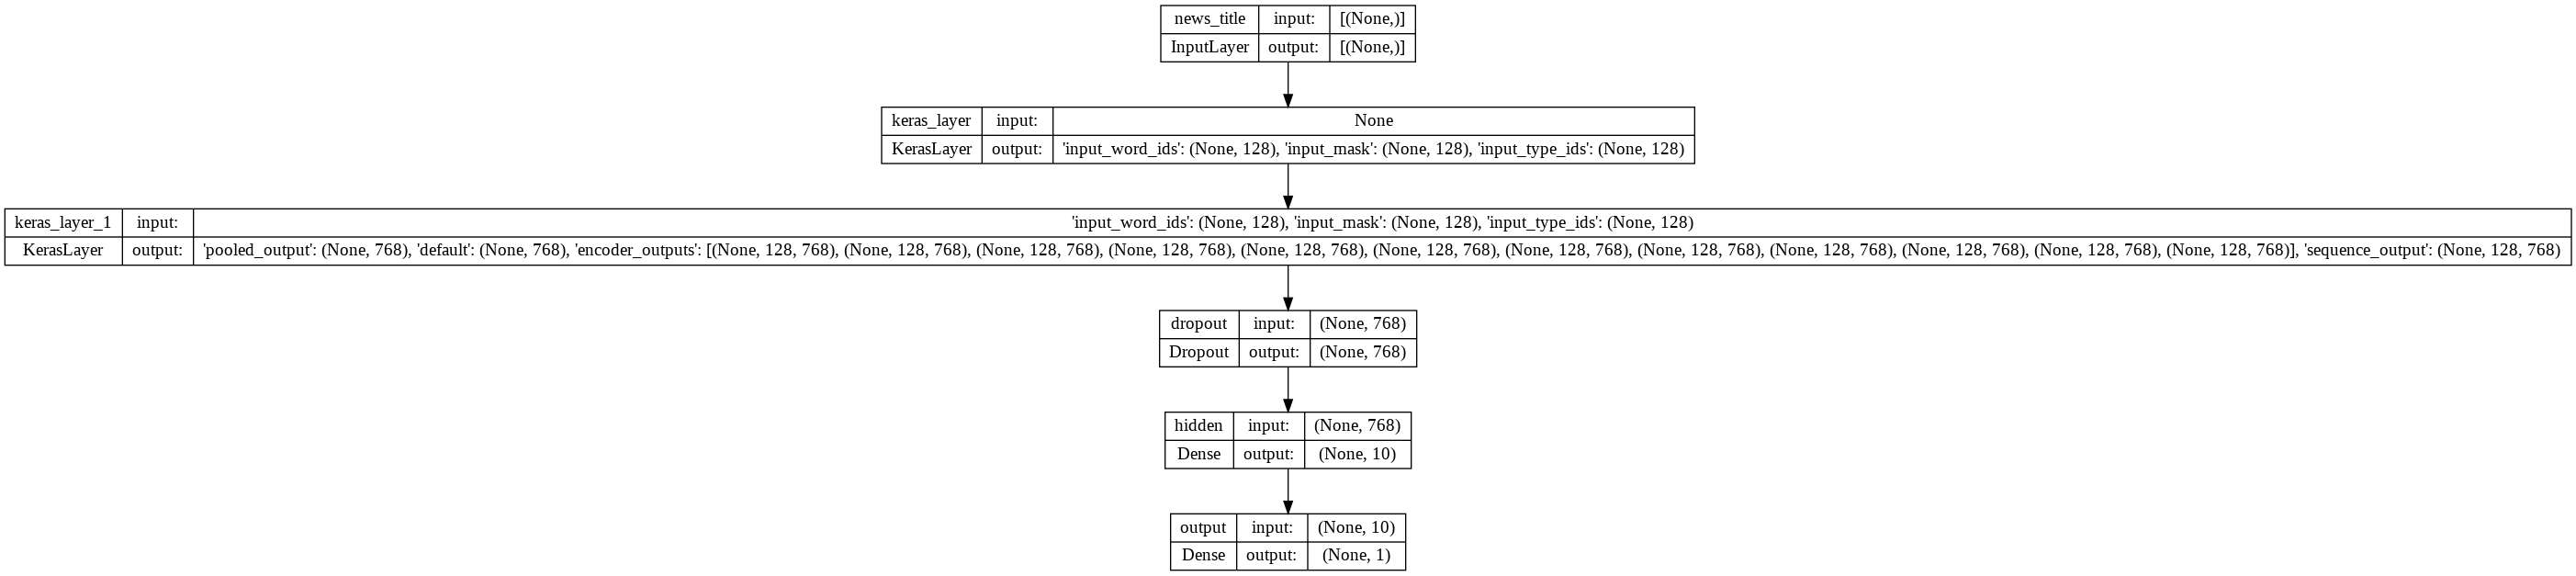

In [78]:
import tensorflow.keras as keras
keras.utils.plot_model(model, "drive/My Drive/bert_model.png", show_shapes=True)

[]

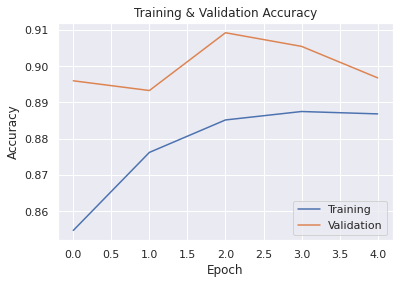

In [83]:
%matplotlib inline
sns.set()

acc = BERT.history['accuracy']
val = BERT.history['val_accuracy']
loss = BERT.history['loss']
val_loss = BERT.history['val_loss']

plt.plot(acc, '-', label='Training')
plt.plot(val, '-', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('drive/My Drive/bert_train_plot',dpi=300)
plt.plot()

[]

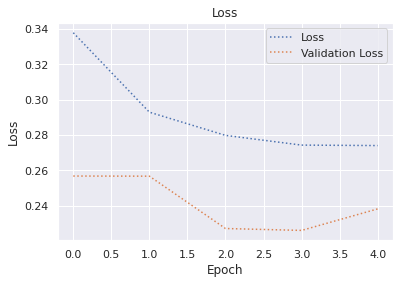

In [82]:
import matplotlib.pyplot as plt

plt.plot(loss, ':', label='Loss')
plt.plot(val_loss, ':', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('drive/My Drive/bert_loss_plot',dpi=300)
plt.plot()

In [ ]:
#Download model with pickle
import pickle 

with open('drive/MyDrive/bert.pkl', 'wb') as files:
    pickle.dump(BERT, files)
    !cat drive/MyDrive/

cat: drive/MyDrive/: Is a directory


In [ ]:
bert_model = pickle.load(open('bert.pkl', 'rb'))
y_pred = bert_model.predict(X_test)

350/350 [==============================] - 1713s 5s/step


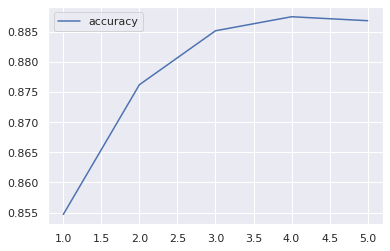

In [84]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(BERT.history, index=range(1,len(BERT.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")
plt.savefig('drive/My Drive/bert_accuracy_plot',dpi=300)